In [36]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from copy import copy

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
#Test
from pympc.control.hybrid_benchmark.build_mip_mld import bigm_dynamics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem set-up

In [2]:
# numeric parameters of the system
m = 1.
k = 100.
b = 5.
g = 10.
h = .02

In [3]:
# symbolic state
yb, yp, ydb = sp.symbols('yb yp ydb')
x = sp.Matrix([yb, yp, ydb])

# symbolic input
ydp = sp.symbols('ydp')
u = sp.Matrix([ydp])

# contact force
f = sp.symbols('f')

# dynamics
x_next = sp.Matrix([ydb, ydp, f/m - g])

# gap function
gap = sp.Matrix([yb - yp - m*g/k])
gap_dot = sp.Matrix([ydb - ydp])

# nominal force
f_nom = - k*gap - b*gap_dot

In [4]:
# discretization method
method = 'zero_order_hold'

# state bounds
x_max = np.array([1., .1, 4.])
x_min = np.array([-.3, -.1, -4.])
f_max = 4.*m*g

# input bounds
u_max = np.array([.3])
u_min = - u_max

# domain bounds
xu = x.col_join(u)
xu_min = np.concatenate((x_min, u_min))
xu_max = np.concatenate((x_max, u_max))

In [5]:
# dynamics n.1 (ball in the air)
f1 = 0.
S1 = AffineSystem.from_symbolic_continuous(x, u, x_next.subs(f, f1), h, method)

# domain n.1
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_symbolic_inequality(xu, -gap)
assert D1.bounded
assert not D1.empty

In [6]:
# dynamics n.2 (paddle pulling ball)
S2 = copy(S1)

# domain n.2
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_symbolic_inequality(xu, gap)
D2.add_symbolic_inequality(xu, f_nom)
assert D2.bounded
assert not D2.empty

In [7]:
# dynamics n.3 (paddle pushing ball)
S3 = AffineSystem.from_symbolic_continuous(x, u, x_next.subs(f, f_nom[0]), h, method)

# domain n.3
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_symbolic_inequality(xu, gap)
D3.add_symbolic_inequality(xu, - f_nom)
D3.add_inequality( # maximum force < 5 m g
    np.array([[-k, k, -b, b]]),
    np.array([f_max - m*g])
)
assert D3.bounded
assert not D3.empty


In [8]:
# list of dynamics
S_list = [S1, S2, S3]

# list of domains
D_list = [D1, D2, D3]

In [28]:
# PWA system
S = PieceWiseAffineSystem(S_list, D_list)

# controller parameters
N = 80
Q = np.diag([5.,50.,.1])*h
R = np.diag([10.])*h

# terminal set and cost
P = Q
X_N = Polyhedron.from_bounds(*[np.zeros(3)]*2)

In [45]:
M1,M2=bigm_dynamics(S)

TypeError: can only concatenate list (not "int") to list

In [44]:
print(M1)
print(M2)

[0.2040714308160405, 0.10600000000000218, 4.335119952677512]
[-0.3399546767468708, -0.10599999999999898, -3.767942725955677]


In [47]:
# initial condition
x0 = np.array([1., .0, .0])
N=70
# MI formulations
method = 'CH'
norm = 'two'
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)

Discarded solution information
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 3308 rows, 1963 columns and 9538 nonzeros
Model fingerprint: 0x10c50e5d
Model has 283 quadratic objective terms
Variable types: 1753 continuous, 210 integer (210 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2213 rows and 1348 columns
Presolve time: 0.06s
Presolved: 1095 rows, 615 columns, 3509 nonzeros
Presolved model has 197 quadratic objective terms
Variable types: 533 continuous, 82 integer (82 binary)

Root relaxation: objective 1.089791e+00, 2299 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  

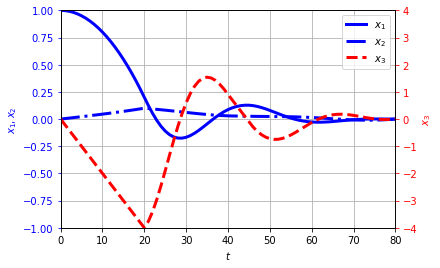

In [13]:
# plot state trajectory
time = range(N+1)
fig, ax1 = plt.subplots()
ax1.set_xlabel(r'$t$')
ax1.grid(True)

# position of the ball and the paddle (x1 and x3)
x1_plot = ax1.plot(time, [x_t[0] for x_t in x_mip], 'b-', label=r'$x_1$', linewidth=3)
x2_plot = ax1.plot(time, [x_t[1] for x_t in x_mip], 'b-.', label=r'$x_2$', linewidth=3)
x12_lim = max([-x_min[0], x_max[0], -x_min[1], x_max[1]])
ax1.set_ylim([-x12_lim, x12_lim])
ax1.set_ylabel(r'$x_1, x_2$', color='b')
ax1.tick_params('y', colors='b')
plt.legend()

# velocity of the ball (x2)
ax2 = ax1.twinx()
x3_plot = ax2.plot(time, [x_t[2] for x_t in x_mip], 'r--', label=r'$x_3$', linewidth=3)
x3_lim = max([-x_min[2],x_max[2]])
ax2.set_ylim([-x3_lim, x3_lim])
ax2.set_ylabel(r'$x_3$', color='r')
ax2.tick_params('y', colors='r')

# plot
x_plot = x1_plot + x2_plot + x3_plot
labels = [xi_plot.get_label() for xi_plot in x_plot]
ax1.set_xlim([0,N])
ax1.legend(x_plot, labels)
plt.show()

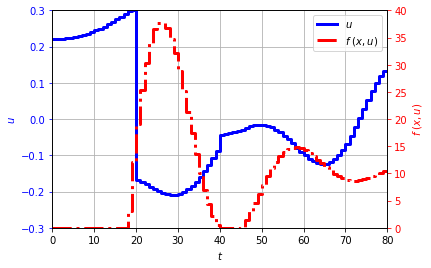

In [12]:
# plot input sequence and contact force
f = [max(k*(x_mip[t][1]-x_mip[t][0]) + b*(u_mip[t][0]-x_mip[t][2]) + m*g, 0.) for t in range(N)]
fig, ax1 = plt.subplots()
ax1.set_xlabel(r'$t$')
ax1.grid(True)

# input
u_plot = ax1.step(time, [u_mip[0][0]] + [u_t[0] for u_t in u_mip], 'b', linestyle='-', label=r'$u$', linewidth=3)
u_lim = max([-u_min[0], u_max[0]])
ax1.set_ylim([-u_lim, u_lim])
ax1.set_ylabel(r'$u$', color='b')
ax1.tick_params('y', colors='b')
plt.legend()

# force
ax2 = ax1.twinx()
f_plot = ax2.step(time, [f[0]] + [f_t for f_t in f], 'r', linestyle='-.', label=r'$f \ (x,u)$', linewidth=3)
ax2.set_ylim([0, f_max])
ax2.set_ylabel(r'$f \ (x,u)$', color='r')
ax2.tick_params('y', colors='r')

# plot
fu_plot = u_plot + f_plot
labels = [fui_plot.get_label() for fui_plot in fu_plot]
ax1.set_xlim([0,N])
ax1.legend(fu_plot, labels)
plt.show()